## Surprise Housing Assignment Part 1

#### Problem Statement:

A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia. The data is provided in the CSV file below.

The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.

 

The company wants to know:

 - Which variables are significant in predicting the price of a house, and
 - How well those variables describe the price of a house.

Steps:
    
    1. Data Analysis
    2. EDA
    3. Model building
    4. Ridge and Lasso model and comparasion

In [940]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler

import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Importing the warning library
import warnings
warnings.filterwarnings("ignore")

In [941]:
sh_df = pd.read_csv("train.csv")
sh_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [942]:
sh_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

#### Data Cleaning

###### Find Missing values

In [943]:
# Number of missing values in each column of training data
def missing_values():
    total = sh_df.isnull().sum().sort_values(ascending=False)
    percent = round(sh_df.isnull().sum() * 100 / len(sh_df), 2).sort_values(ascending = False)
    
    features = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    
    features = features[features.Total != 0]
    
    return features

missing_values()

,Total,Percent
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
FireplaceQu,690,47.26
LotFrontage,259,17.74
GarageYrBlt,81,5.55
GarageCond,81,5.55
GarageType,81,5.55
GarageFinish,81,5.55


Based on observation, we can drop the following columns

- Id
- PoolQC
- MiscFeature
- Alley
- Fence
- FireplaceQu
- LotFrontage

##### Remove missing columns

In [944]:
sh_df.drop(['Id','PoolQC','MiscFeature','Alley','Fence', 'FireplaceQu', 'LotFrontage'], axis=1, inplace = True)

In [945]:
sh_df.shape

(1460, 74)

In [946]:
print(sh_df['PoolArea'].value_counts())
print(sh_df['MiscVal'].value_counts())
print(sh_df['3SsnPorch'].value_counts())

0      1453
512       1
648       1
576       1
555       1
480       1
519       1
738       1
Name: PoolArea, dtype: int64
0        1408
400        11
500         8
700         5
450         4
600         4
2000        4
1200        2
480         2
15500       1
800         1
350         1
3500        1
1300        1
54          1
620         1
560         1
1400        1
8300        1
1150        1
2500        1
Name: MiscVal, dtype: int64
0      1436
168       3
144       2
180       2
216       2
290       1
153       1
96        1
23        1
162       1
182       1
196       1
320       1
245       1
238       1
508       1
140       1
130       1
407       1
304       1
Name: 3SsnPorch, dtype: int64


In [947]:
#drop these columns as it dominated by one value
sh_df = sh_df.drop(['PoolArea','MiscVal','3SsnPorch'],axis=1)

In [948]:
# Dropping columns which have high values missing + I
sh_df.drop(['MoSold','Street', 'Utilities'], axis=1, inplace = True)

In [949]:
number_columns = sh_df.select_dtypes(include = ['float64', 'int64'])
number_columns.shape

(1460, 32)

In [950]:
sh_df.dropna(inplace = True)

In [951]:
sh_df.shape

(1338, 68)

In [952]:
missing_values()

,Total,Percent


### EDA Analysis

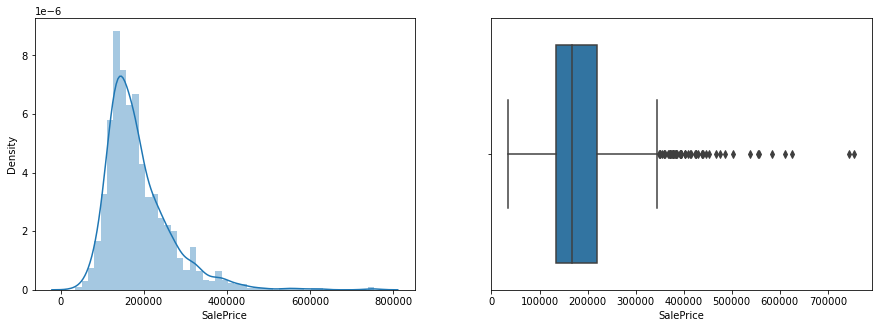

<Figure size 720x576 with 0 Axes>

In [953]:
f, axes = plt.subplots(1, 2, figsize = (15, 5))
plt.figure(figsize = [10, 8])
sns.distplot(sh_df['SalePrice'], ax=axes[0])
sns.boxplot(sh_df['SalePrice'],  orient='v' , ax=axes[1])
plt.show()

In [954]:
print('Skewness: %f' % sh_df['SalePrice'].skew())

Skewness: 1.943686


The skewnss is gratedthan 1, so the target variable is highly skewed

In [955]:
# Check the Kurtosis of a target variable
sh_df['SalePrice'].kurt()

6.815307479336196

The Kurtosis is grater than 1, so the distribution of target variable is higly peaked

In [956]:
# So we will log transform our target variable
# Log transform the target variable

sh_df['SalePrice'] = np.log(sh_df['SalePrice'])

In [957]:
print(sh_df['SalePrice'].skew())
print(sh_df['SalePrice'].kurt())

0.29010991418466675
0.7573111804350656


##### Both skew and kurtosis are lessthan 1

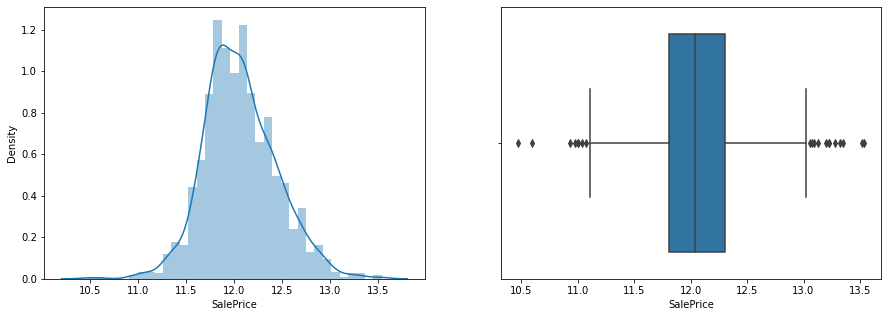

<Figure size 720x576 with 0 Axes>

In [958]:
#Plot the target variable after log transform
f, axes = plt.subplots(1, 2, figsize = (15, 5))
plt.figure(figsize = [10, 8])
sns.distplot(sh_df['SalePrice'], ax=axes[0])
sns.boxplot(sh_df['SalePrice'],  orient='v' , ax=axes[1])
plt.show()

Now the target variable has normal distribution

#### EDA on Number Columns & Categorical columns

In [959]:
## Extract numerical columns
df_num = sh_df.select_dtypes(include=['int64', 'float64'])
df_num.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,YrSold,SalePrice
0,60,8450,7,5,2003,2003,196.0,706,0,150,...,0,2003.0,2,548,0,61,0,0,2008,12.247694
1,20,9600,6,8,1976,1976,0.0,978,0,284,...,1,1976.0,2,460,298,0,0,0,2007,12.109011
2,60,11250,7,5,2001,2002,162.0,486,0,434,...,1,2001.0,2,608,0,42,0,0,2008,12.317167
3,70,9550,7,5,1915,1970,0.0,216,0,540,...,1,1998.0,3,642,0,35,272,0,2006,11.849398
4,60,14260,8,5,2000,2000,350.0,655,0,490,...,1,2000.0,3,836,192,84,0,0,2008,12.429216


In [960]:
## Extract categorical columns
df_cat = sh_df.select_dtypes(include='object')
df_cat.head()

,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,...,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal


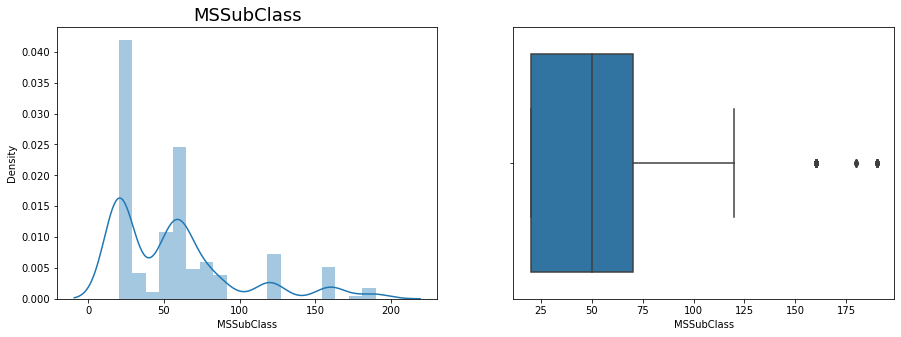

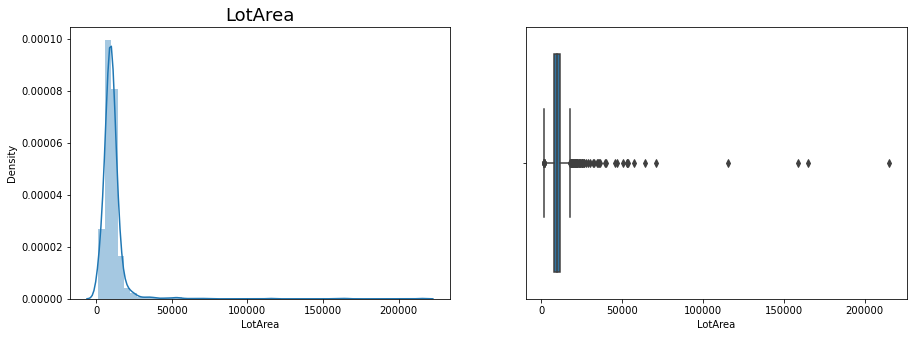

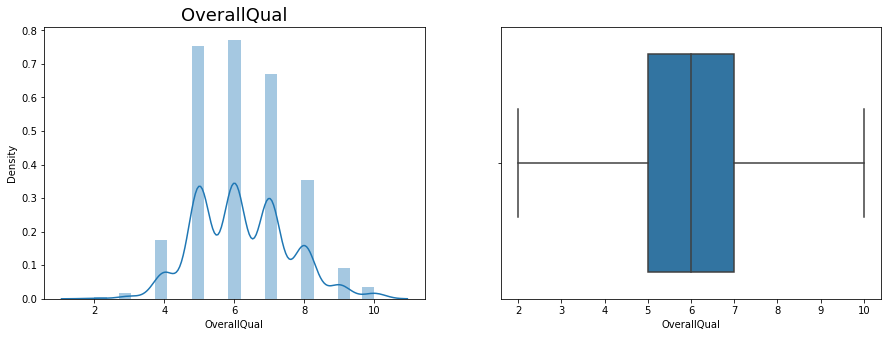

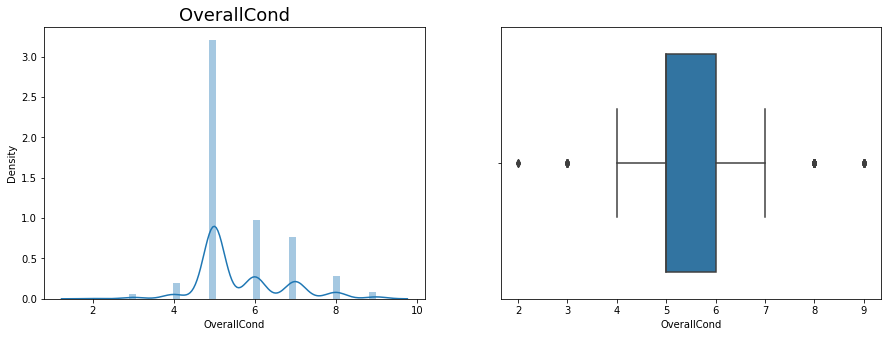

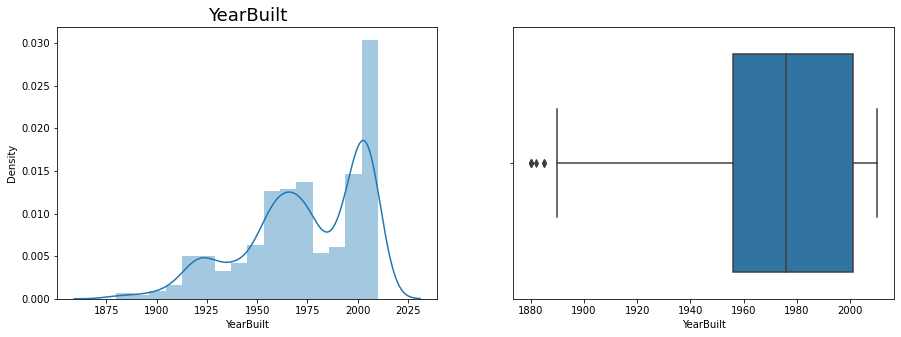

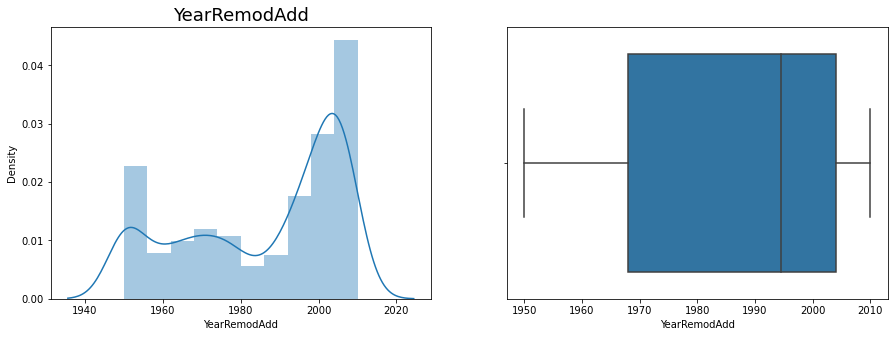

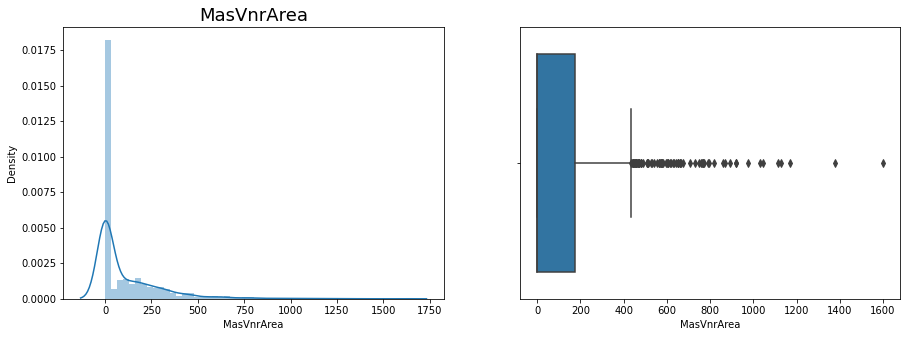

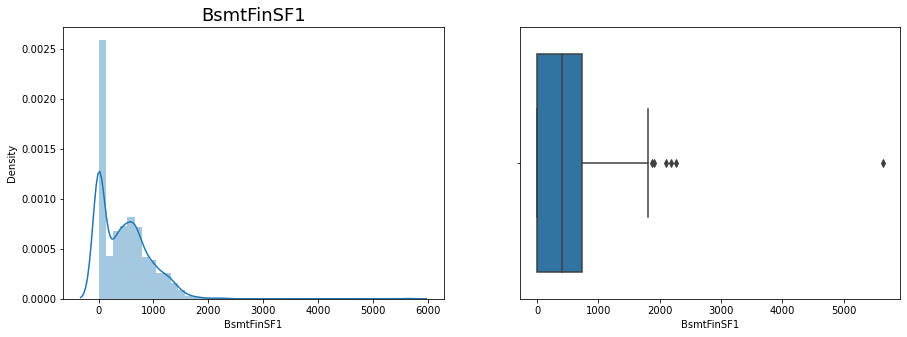

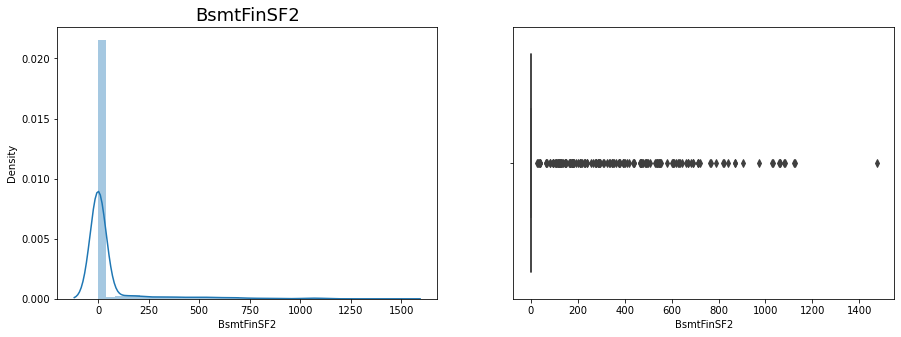

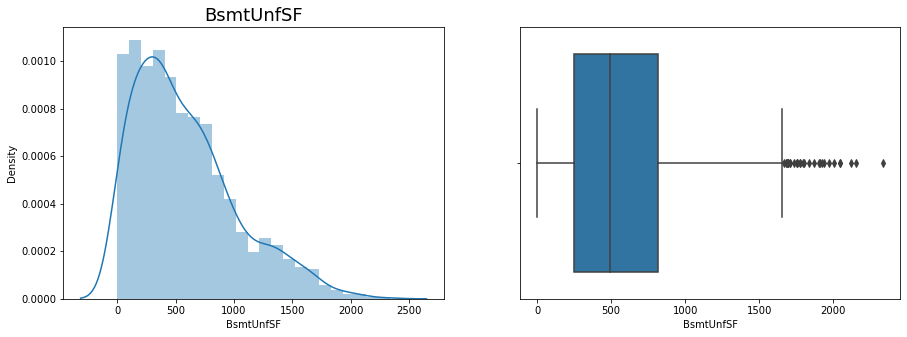

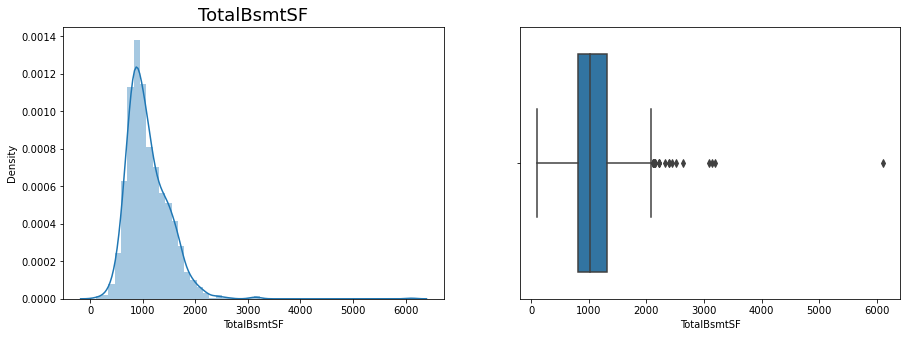

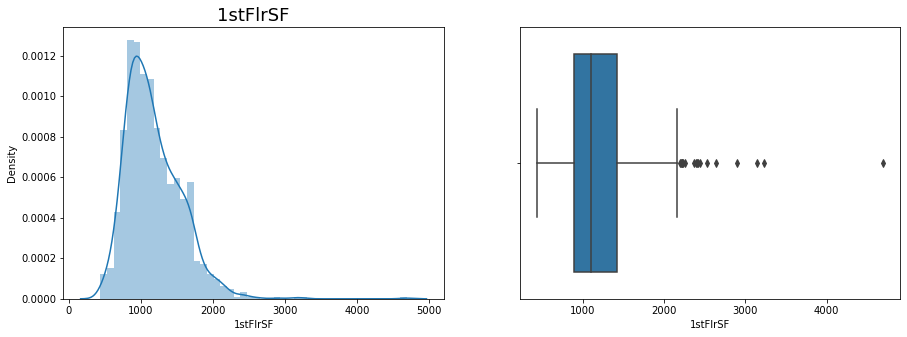

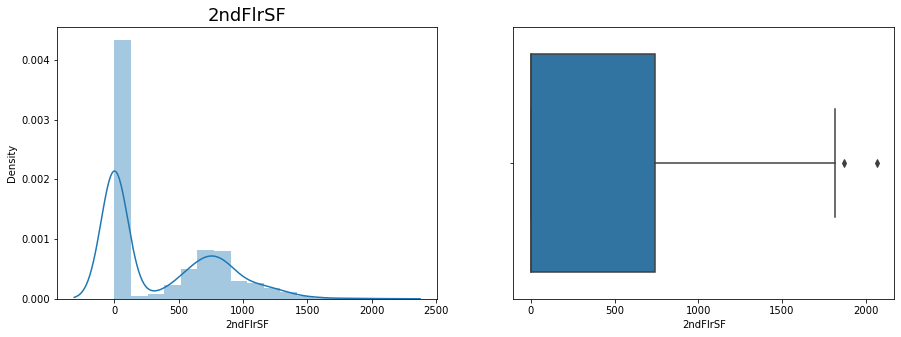

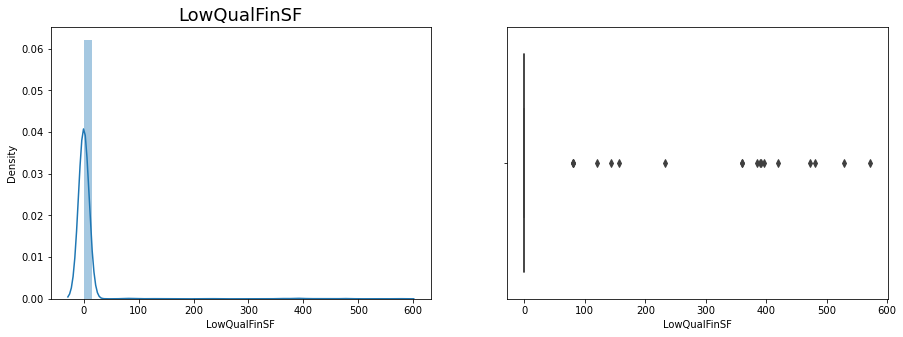

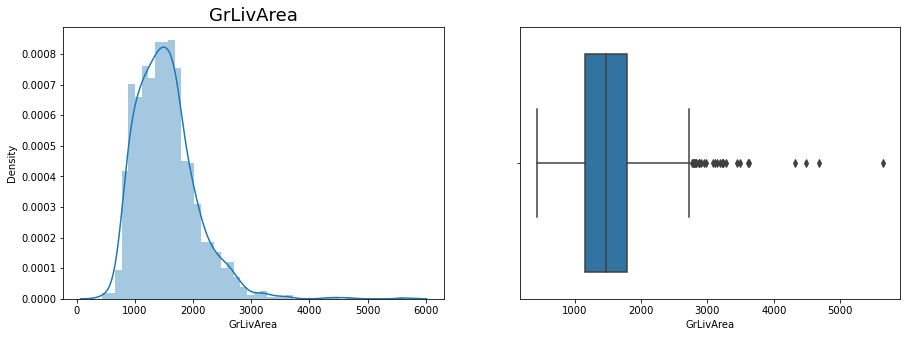

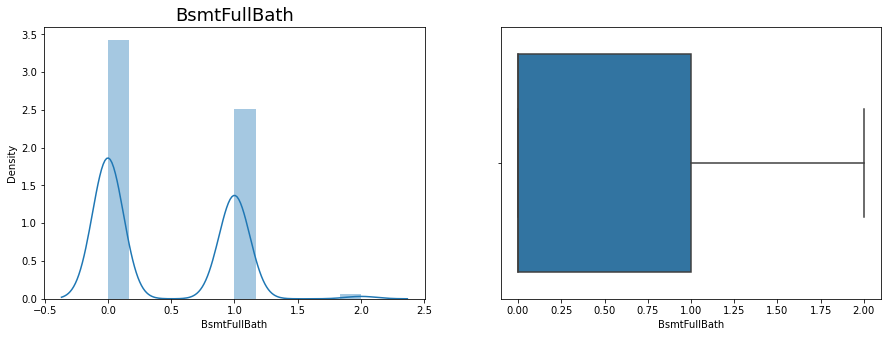

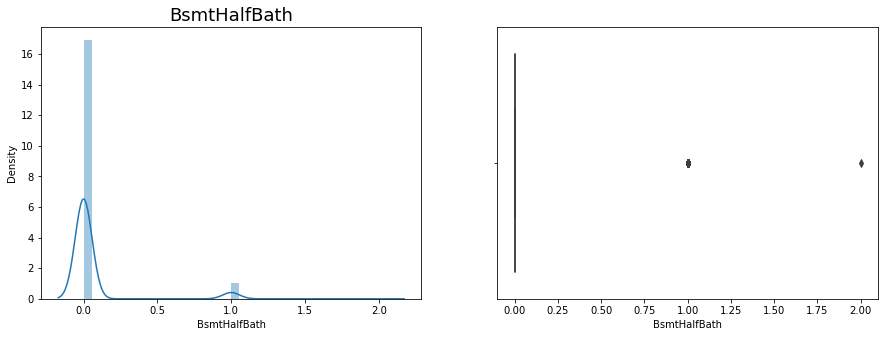

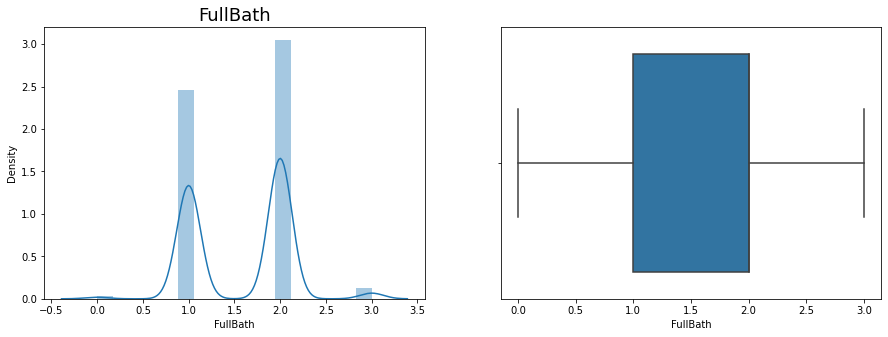

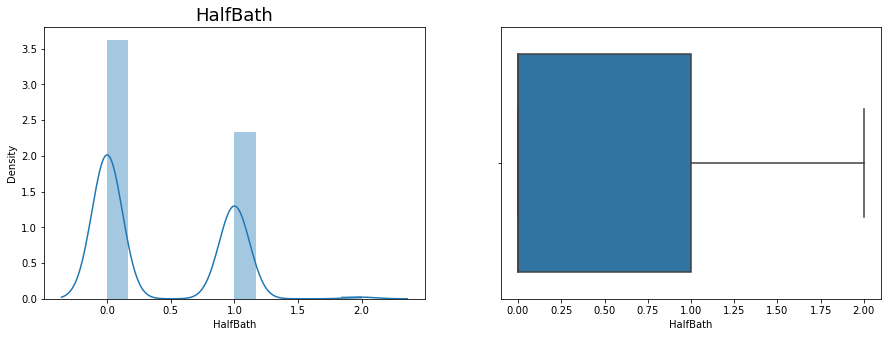

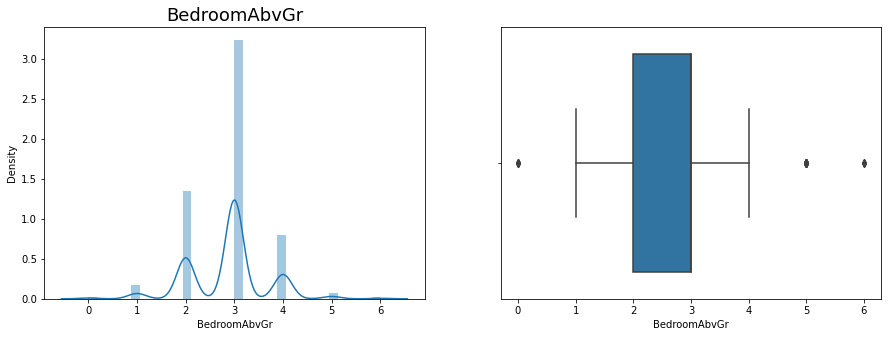

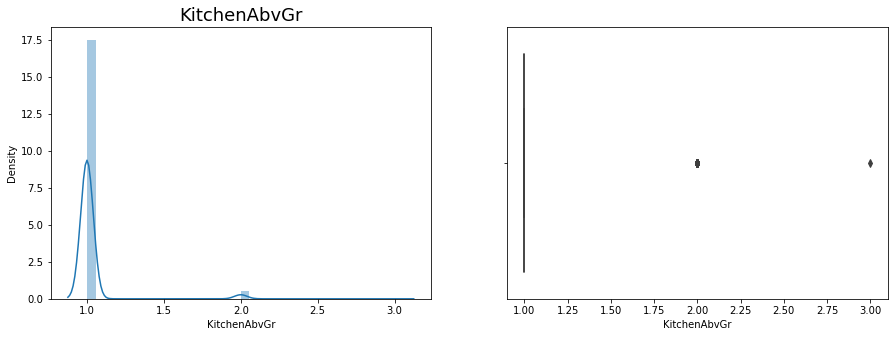

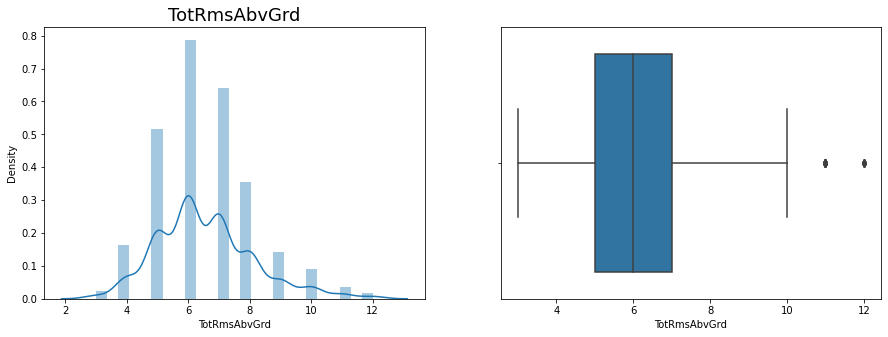

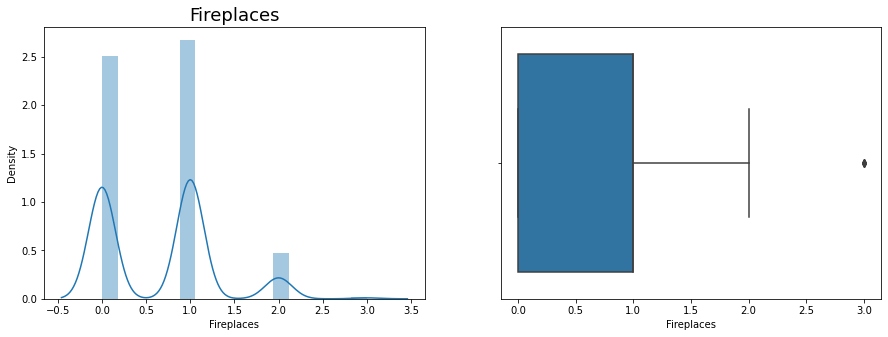

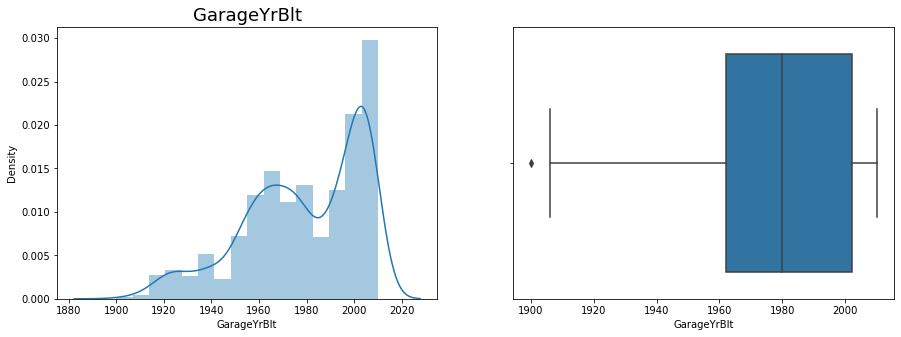

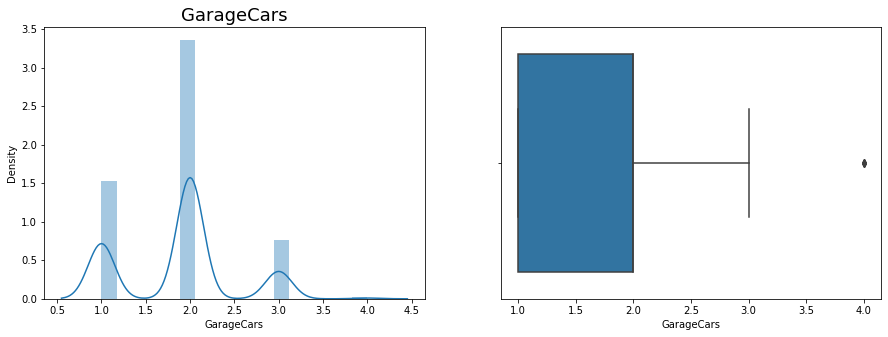

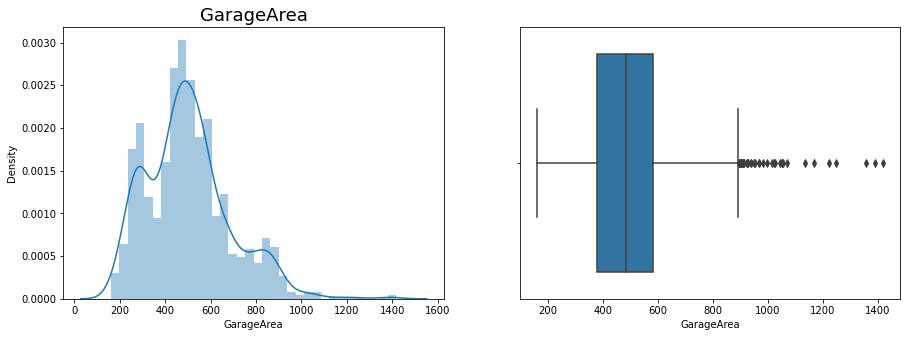

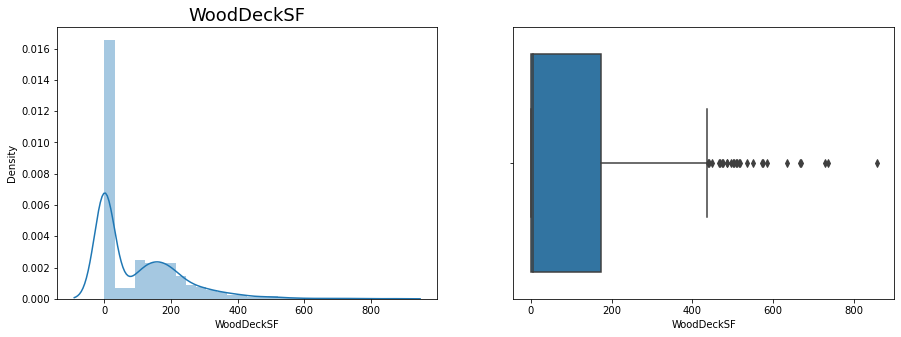

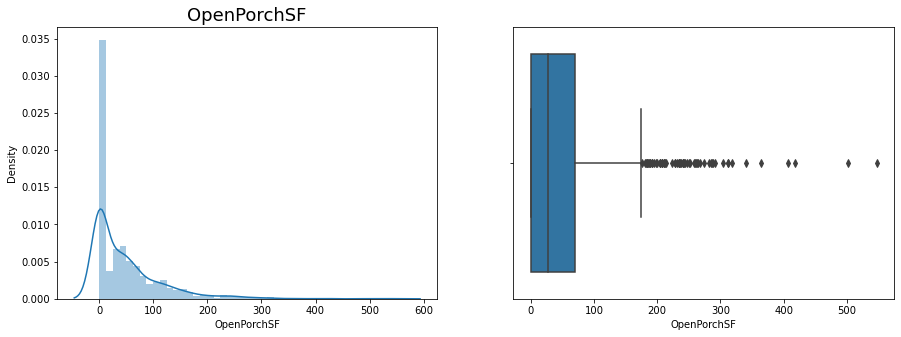

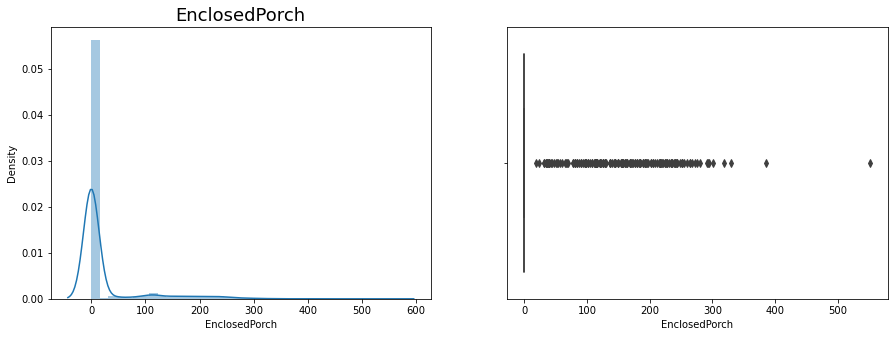

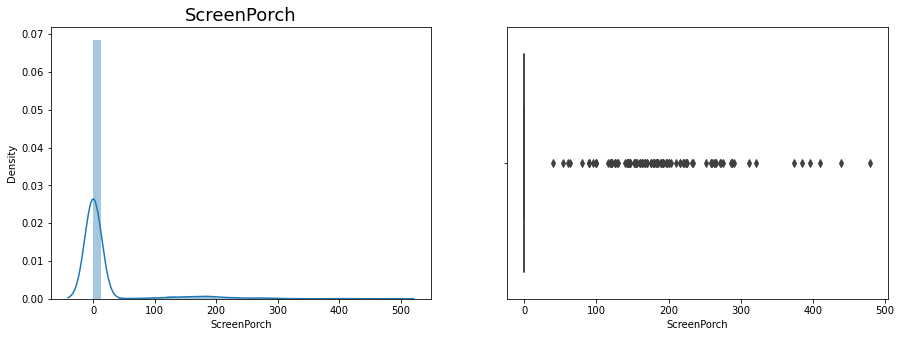

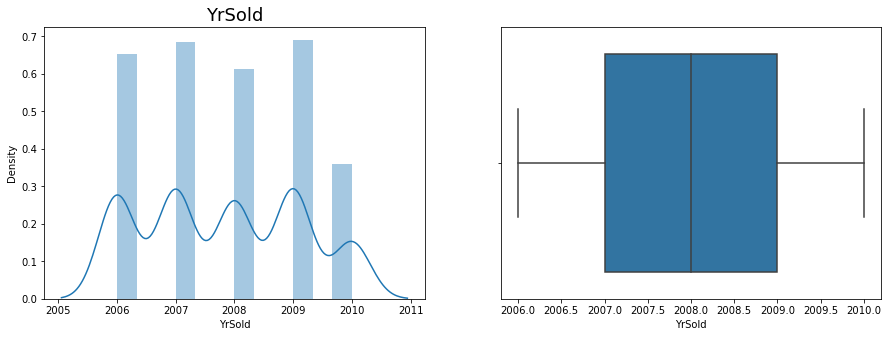

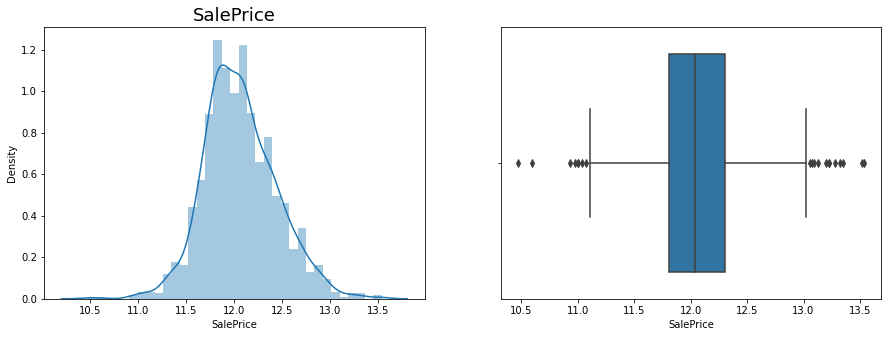

In [961]:
for col in df_num.columns:
    plt.figure(figsize=(15,5))
    
    plt.subplot(1,2,1)
    plt.title(col, fontdict={'fontsize': 18})
    sns.distplot(df_num[col])
    
    plt.subplot(1,2,2)
    sns.boxplot(df_num[col])
    plt.show()  

##### Observations

- Many of the numirical columns are not distributed properly, it is either right or left skewed
- Found outliers found on most of the columns, outliers should be eliminated

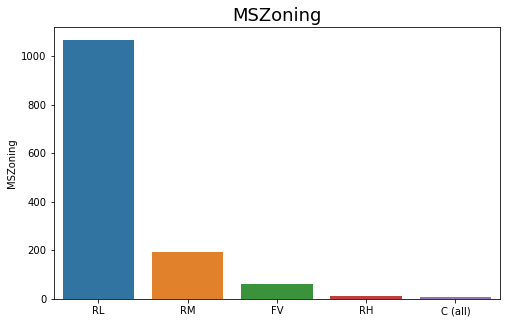

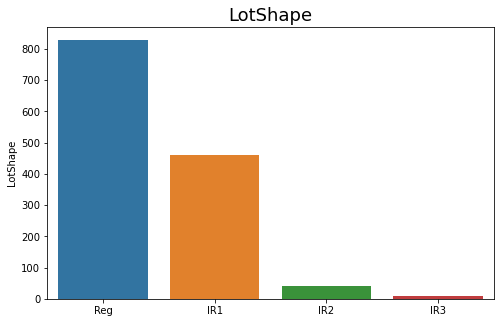

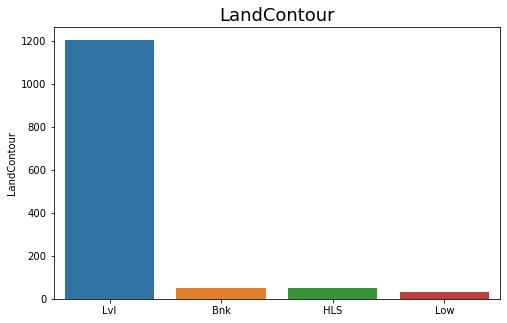

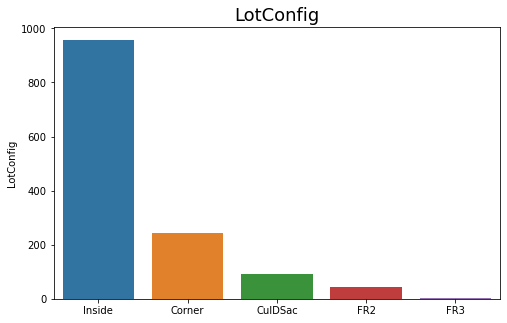

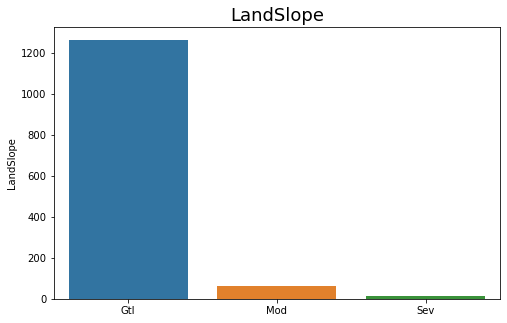

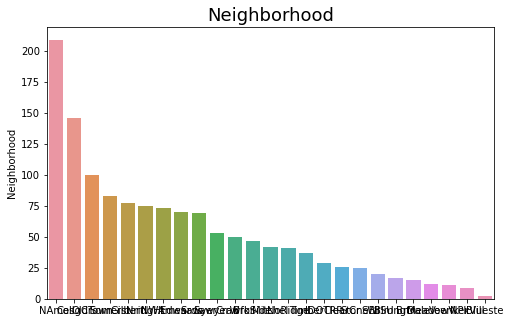

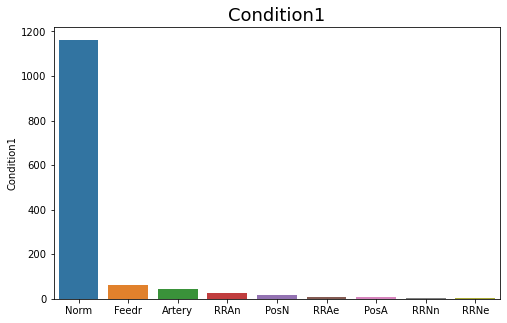

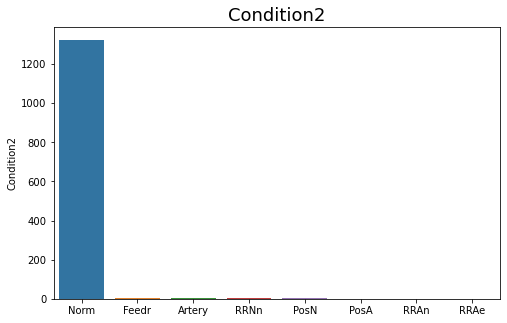

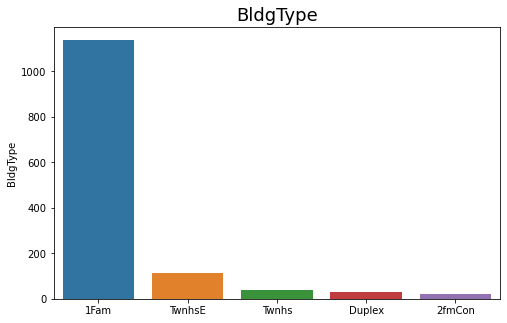

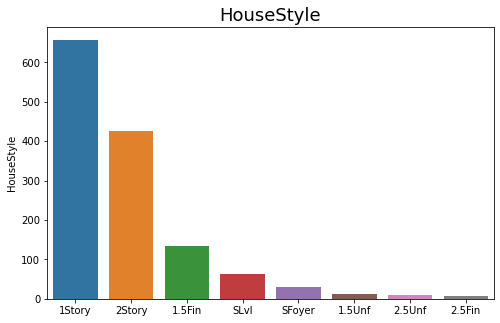

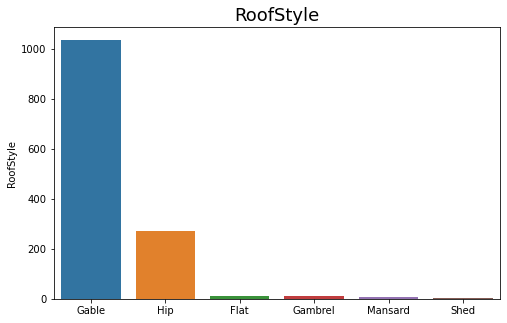

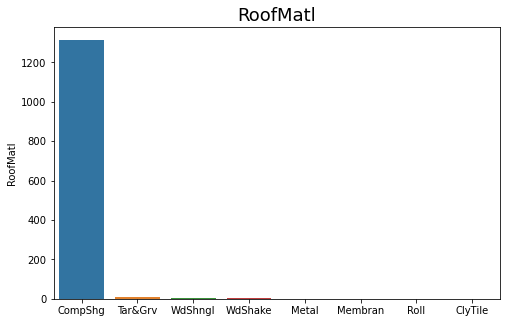

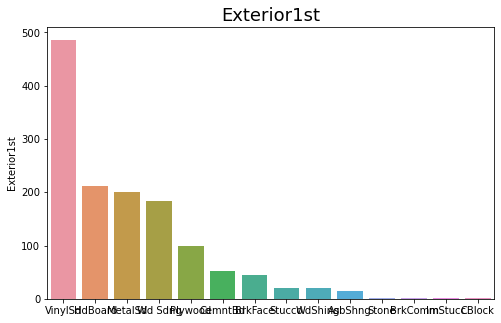

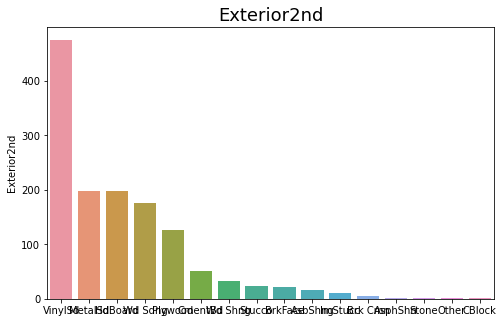

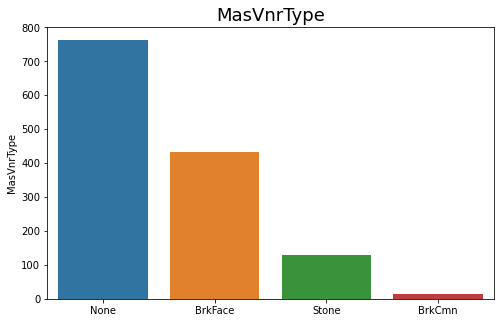

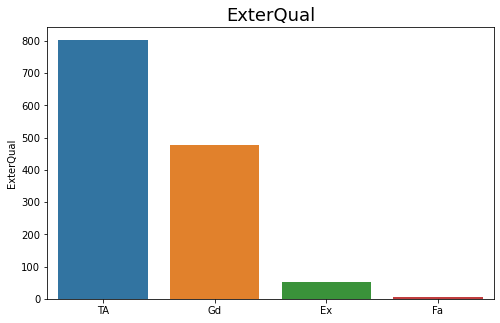

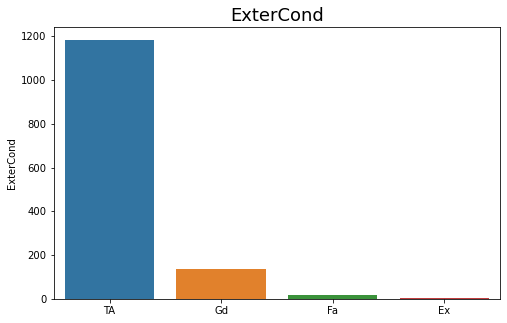

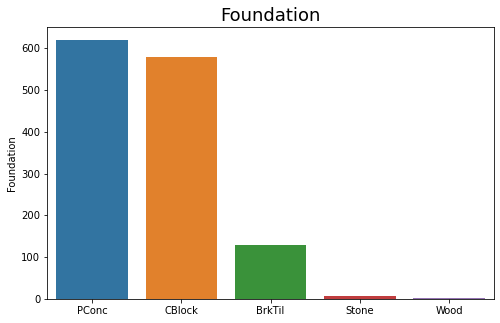

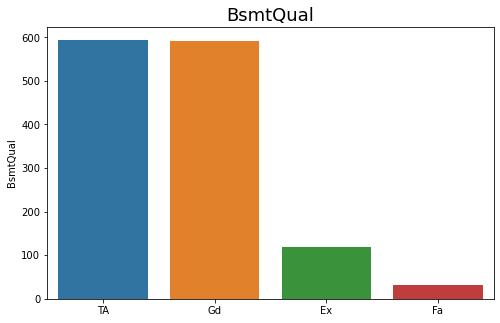

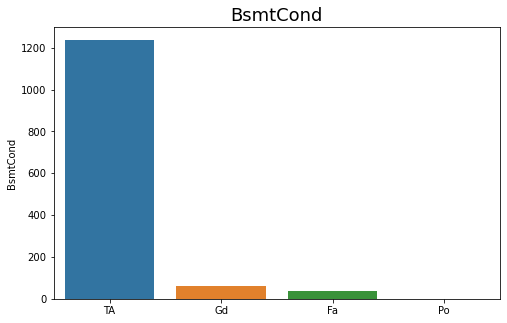

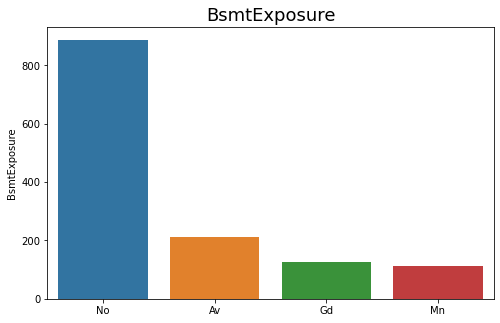

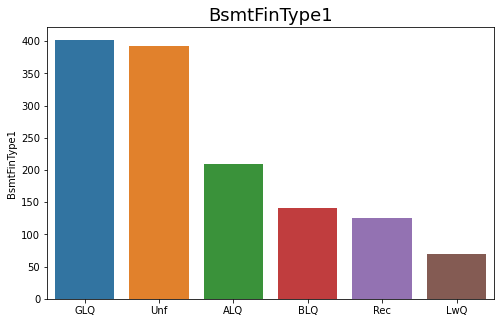

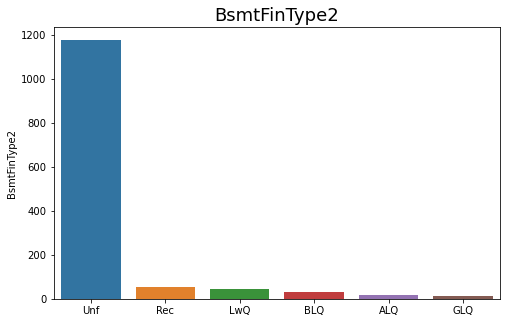

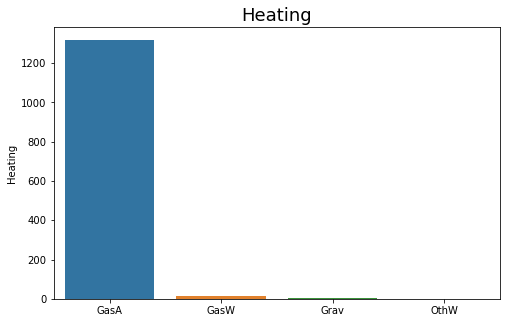

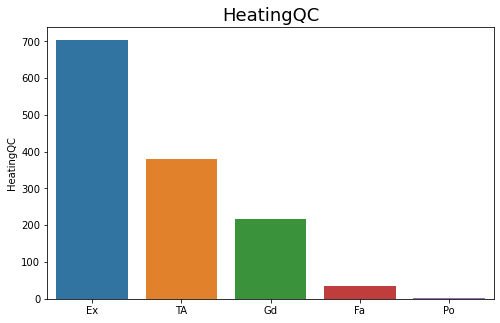

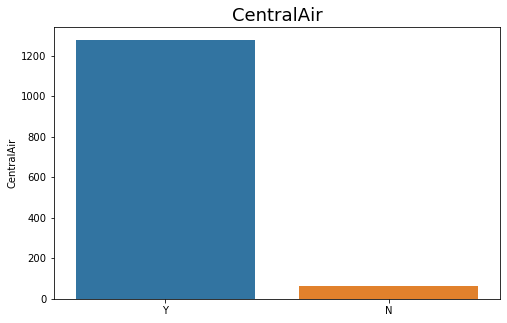

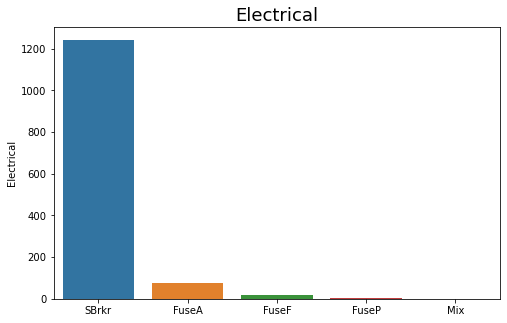

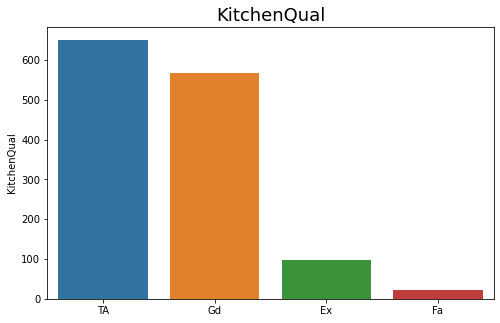

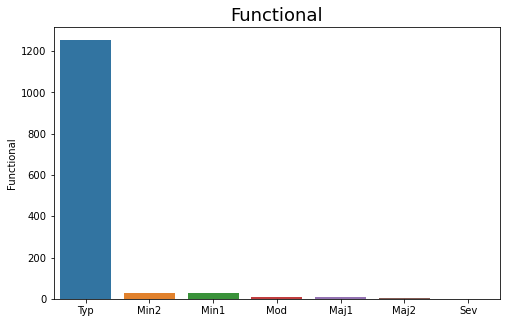

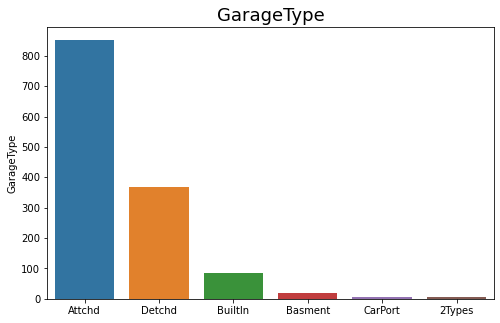

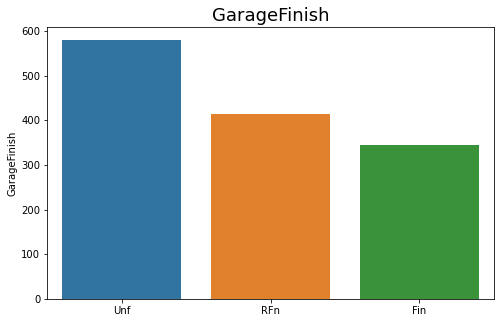

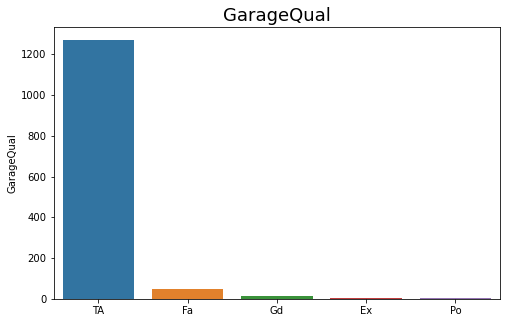

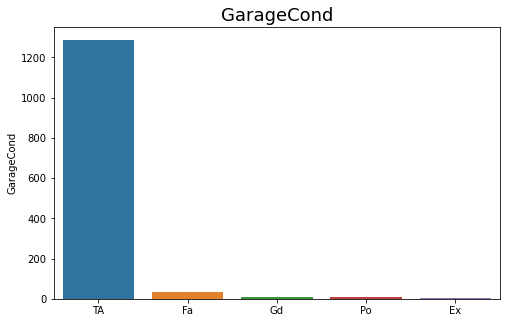

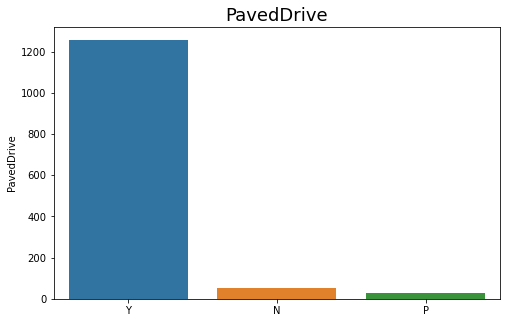

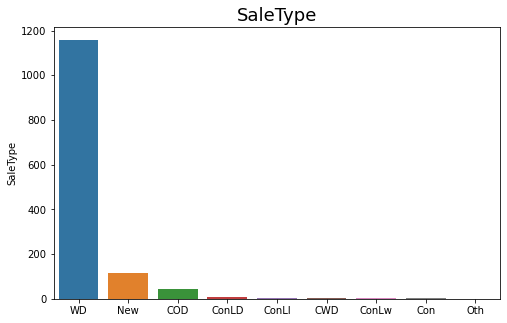

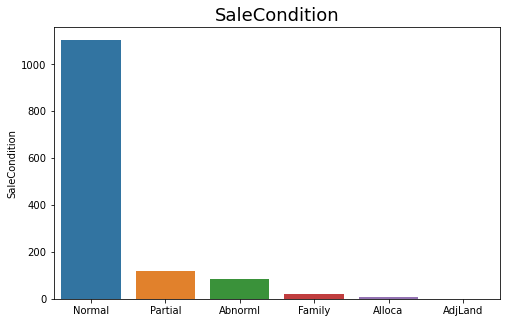

In [962]:
## Visualizing the levels of categorical columns using bar plots
for col in df_cat.columns:
    plt.figure(figsize=(8,5))
    plt.title(col, fontdict={'fontsize': 18})
    sns.barplot(df_cat[col].value_counts().index, df_cat[col].value_counts())
    plt.show()

- So we observe from above value counts and bar plots that there is no column with single unique value that we could remove.

### Find the variables which are significient for the target variable

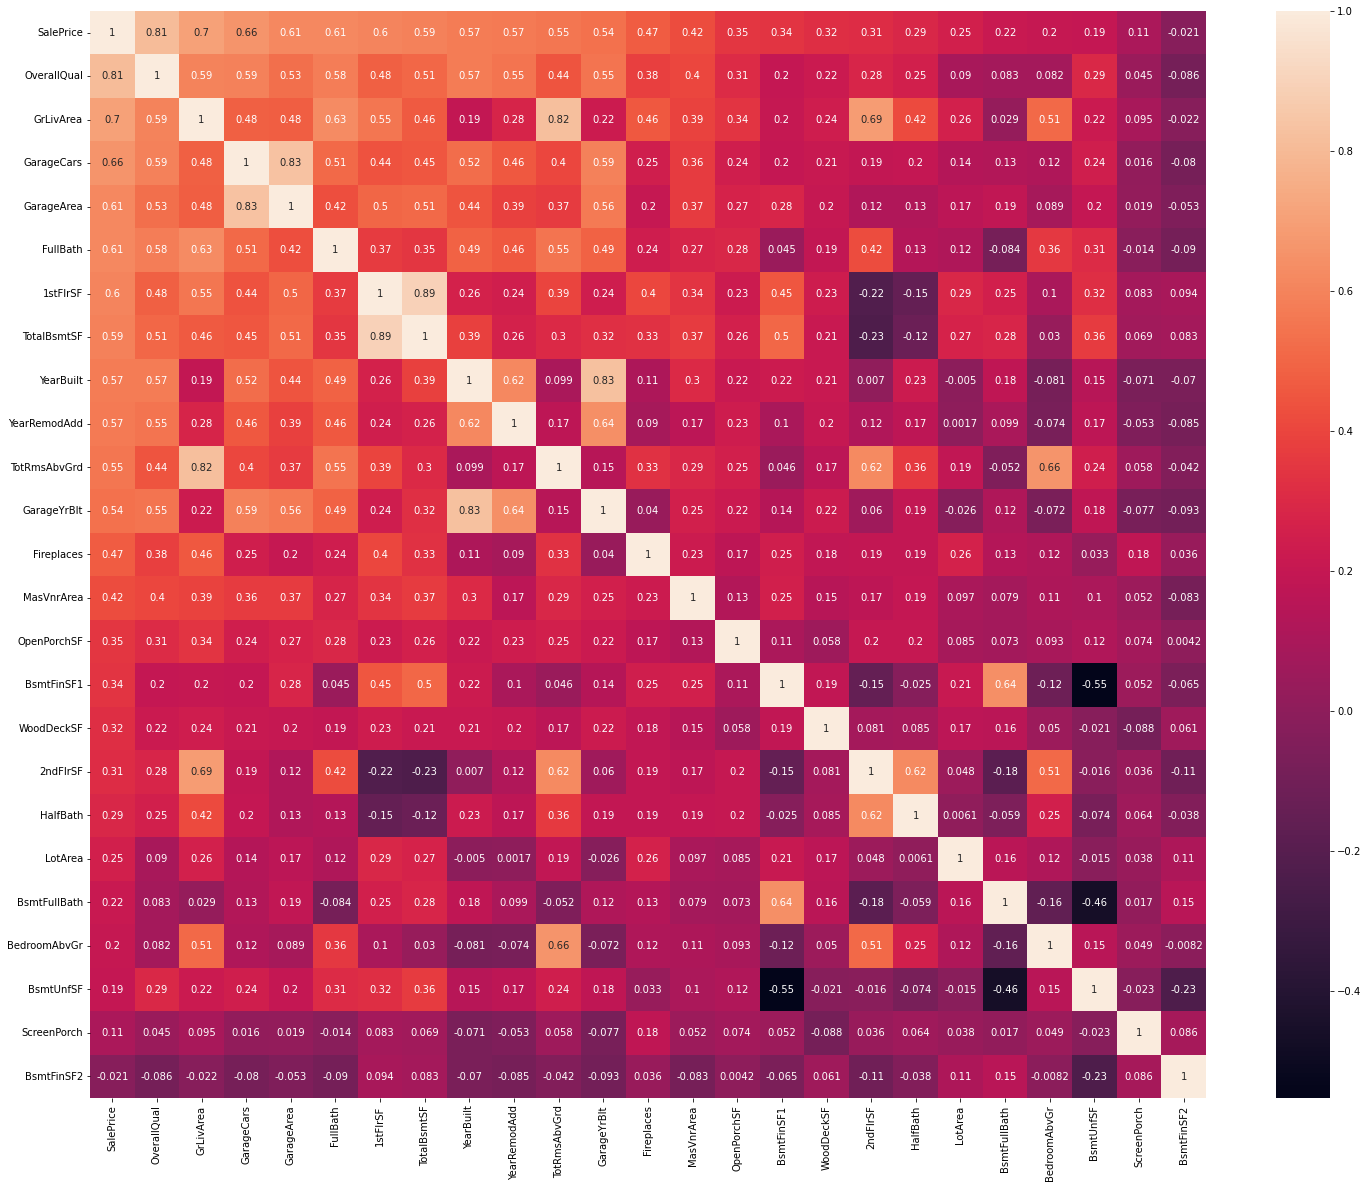

In [963]:
plt.figure(figsize=(25,20))

# number of variables which have the highest correlation with 'Sales price'
n = 25
corrmat = sh_df.corr()

cols = corrmat.nlargest(n, 'SalePrice')['SalePrice'].index

sns.heatmap(sh_df[cols].corr(), annot=True);

Observations:
    
- Target variable is higly corrleated with GrLivArea, GarageCars, GarageArea

In [964]:
corr_val = sh_df[list(sh_df.dtypes[sh_df.dtypes != 'object'].index)].corr()
corr_coef = corr_val[corr_val['SalePrice'] > 0.5]['SalePrice'].sort_values(ascending=False)
print(corr_coef[1:])
corr_coef_cols = [idx for idx in corr_coef.index]

OverallQual     0.807486
GrLivArea       0.704739
GarageCars      0.660141
GarageArea      0.612695
FullBath        0.612604
1stFlrSF        0.599786
TotalBsmtSF     0.589520
YearBuilt       0.572592
YearRemodAdd    0.565870
TotRmsAbvGrd    0.551437
GarageYrBlt     0.536262
Name: SalePrice, dtype: float64


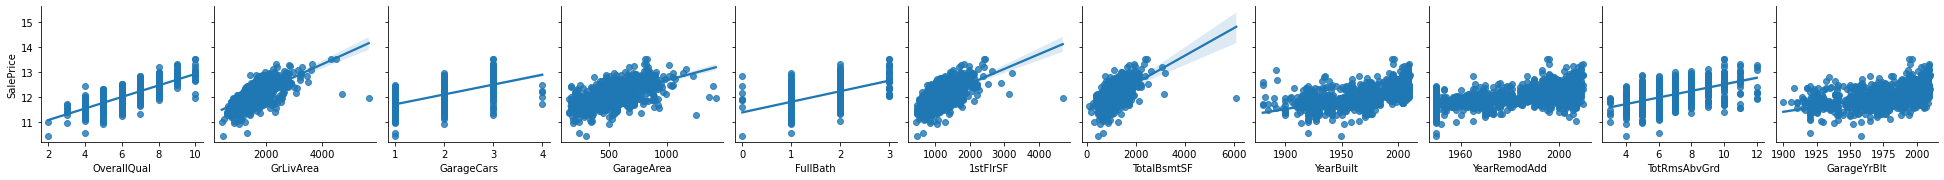

In [965]:
# Draw Pair plot for the correlated features
sns.pairplot(sh_df, x_vars=corr_coef_cols[1:], y_vars=[corr_coef_cols[0]], kind="reg" )

In [966]:
sh_df.shape

(1338, 68)

#### Dummy variable creation using One Hot Encoding

In [967]:
## One hot encoding the categorical columns
df_cat_encoded = pd.get_dummies(df_cat, drop_first=True)
df_cat_encoded.head()

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,1,0
1,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,1,0
2,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
3,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0


In [968]:
## Check the dimensions
df_cat_encoded.shape

(1338, 189)

#### Outliers

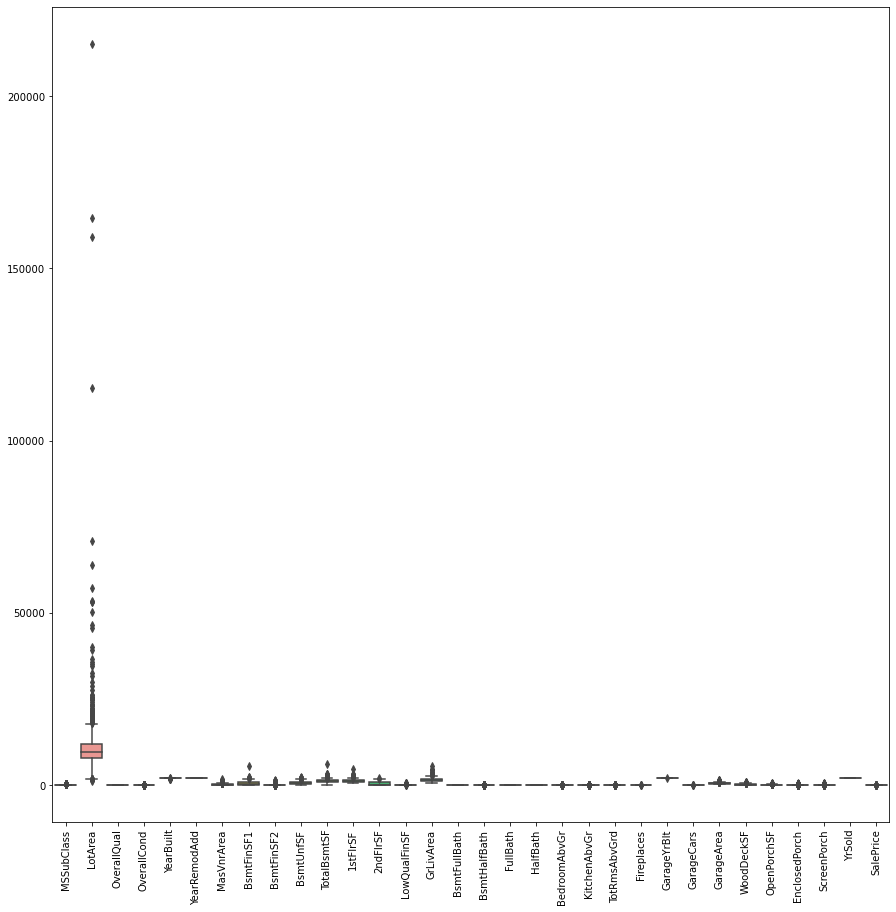

In [969]:
## Check the boxplots to view outliers in numerical columns
plt.figure(figsize=[15,15])
plt.xticks(rotation=90)
sns.boxplot(data=df_num);

### Removing Outliers

In [970]:
## Capping outliers to 5% at lower bound and 95% at upper bound
for col in df_num.columns:
    df_num[col][df_num[col] <= df_num[col].quantile(0.05)] = df_num[col].quantile(0.05)
    df_num[col][df_num[col] >= df_num[col].quantile(0.95)] = df_num[col].quantile(0.95)

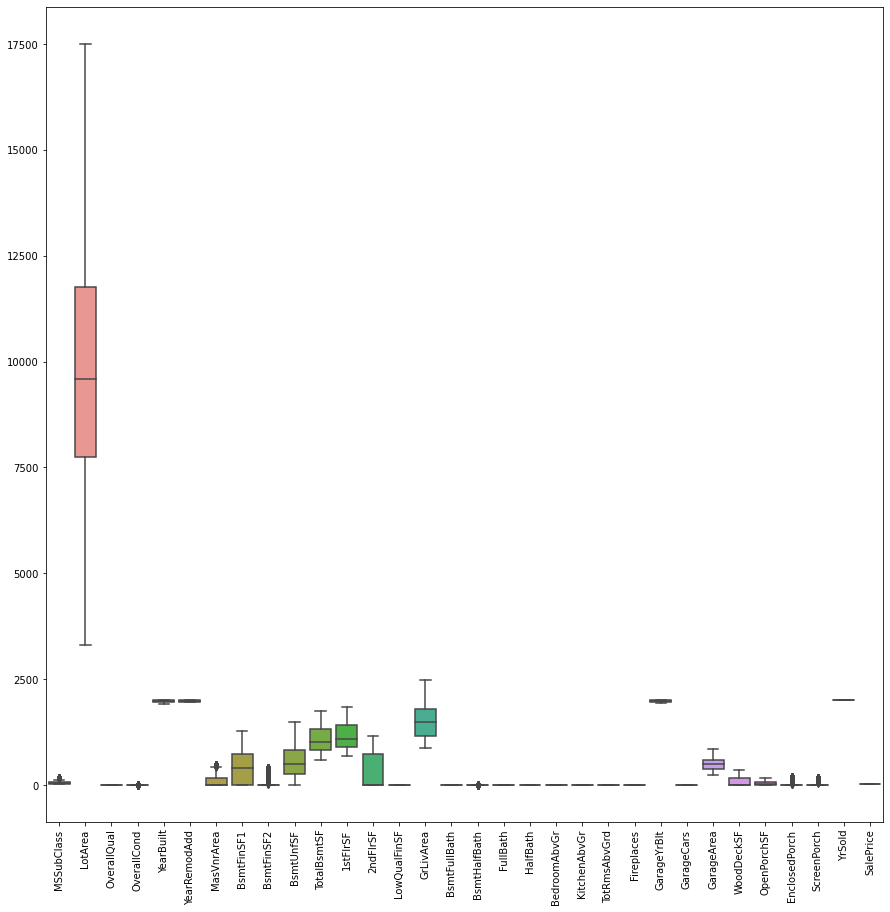

In [971]:
## Check the boxplots again to see if outliers have been treated
plt.figure(figsize=[15,15])
plt.xticks(rotation=90)
sns.boxplot(data=df_num);

In [972]:
## Concatenate the outlier treated numerical columns with one hot encoded categorical columns
df = pd.concat([df_num, df_cat_encoded], axis=1)


## View the first few rows of our dataframe
df.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,8450.0,7,5,2003.00,2003,196.0,706.0,0.0,150.0,...,0,0,0,0,1,0,0,0,1,0
1,20,9600.0,6,8,1976.00,1976,0.0,978.0,0.0,284.0,...,0,0,0,0,1,0,0,0,1,0
2,60,11250.0,7,5,2001.00,2002,162.0,486.0,0.0,434.0,...,0,0,0,0,1,0,0,0,1,0
3,70,9550.0,7,5,1918.85,1970,0.0,216.0,0.0,540.0,...,0,0,0,0,1,0,0,0,0,0
4,60,14260.0,8,5,2000.00,2000,350.0,655.0,0.0,490.0,...,0,0,0,0,1,0,0,0,1,0


<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

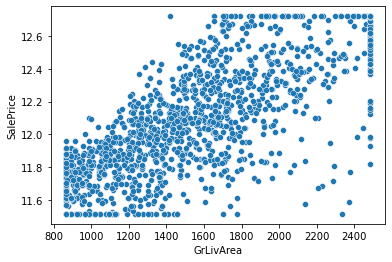

In [973]:
sns.scatterplot(data = df, x = 'GrLivArea', y = 'SalePrice')

Now Our model is ready for model building

### Model building, Tuning and Evulation

In [974]:
#### Split the independent and dependent variables
X = df.drop(['SalePrice'], axis = 1).copy()
X.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,8450.0,7,5,2003.00,2003,196.0,706.0,0.0,150.0,...,0,0,0,0,1,0,0,0,1,0
1,20,9600.0,6,8,1976.00,1976,0.0,978.0,0.0,284.0,...,0,0,0,0,1,0,0,0,1,0
2,60,11250.0,7,5,2001.00,2002,162.0,486.0,0.0,434.0,...,0,0,0,0,1,0,0,0,1,0
3,70,9550.0,7,5,1918.85,1970,0.0,216.0,0.0,540.0,...,0,0,0,0,1,0,0,0,0,0
4,60,14260.0,8,5,2000.00,2000,350.0,655.0,0.0,490.0,...,0,0,0,0,1,0,0,0,1,0


In [975]:
y = df['SalePrice'].copy()
y.head()

0    12.247694
1    12.109011
2    12.317167
3    11.849398
4    12.429216
Name: SalePrice, dtype: float64

In [976]:
#### Split the data into Train & Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle=True)

In [977]:
## View dimensions of train data
print(X_train.shape)
print(y_train.shape)

(1070, 220)
(1070,)


In [978]:
## View dimensions of test data
print(X_test.shape)
print(y_test.shape)

(268, 220)
(268,)


#### Scaling numerical columns

In [979]:
## Create a list of numerical columns to be scaled
num_cols = list(X_train.select_dtypes(include=['int64', 'float64']).columns)
num_cols

['MSSubClass',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 'ScreenPorch',
 'YrSold']

In [980]:
## Create a scaling instance
scaler = MinMaxScaler()

## Scale the numerical columns 
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [981]:
X_train.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
610,0.285714,0.545336,1.00,0.000000,0.920590,0.877193,0.439371,0.706085,0.000000,0.362089,...,0,0,0,0,1,0,0,0,1,0
1402,0.000000,0.243486,0.75,0.000000,0.988656,0.982456,0.000000,0.000000,0.000000,0.868743,...,0,0,1,0,0,0,0,0,0,1
1249,0.000000,0.274318,0.25,0.666667,0.353375,0.000000,0.000000,0.417090,0.232812,0.166183,...,0,0,0,0,1,0,0,0,1,0
1062,1.000000,0.724840,0.25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.447207,...,0,0,0,0,1,0,0,0,1,0
530,0.428571,0.485501,0.50,0.000000,0.784458,0.684211,0.471678,0.611575,0.000000,0.458015,...,0,0,0,0,1,0,0,0,0,0


#### Model Building

In [982]:
## Building a Regression model.
reg = LinearRegression()
reg.fit(X_train,y_train)

LinearRegression()

In [983]:
# Calculating the RFE
rfe = RFE(reg, n_features_to_select  = 20)
rfe = rfe.fit(X_train, y_train)

In [984]:
col=X_train.columns[rfe.support_]
col

Index(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'TotalBsmtSF',
       'GrLivArea', 'Neighborhood_Crawfor', 'Condition1_RRAe',
       'Condition2_PosA', 'Condition2_PosN', 'BldgType_Duplex',
       'RoofMatl_CompShg', 'RoofMatl_Membran', 'RoofMatl_Metal',
       'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl',
       'Foundation_Wood', 'Functional_Sev', 'GarageQual_Po'],
      dtype='object')

#### Model Building with stats API

In [985]:
X_train_new=X_train[col]
X_train_new = sm.add_constant(X_train_new)

#create first model
lr=sm.OLS(y_train,X_train_new)

#fit the model
lr_model=lr.fit()

#Print the summary 
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     453.8
Date:                Sat, 24 Dec 2022   Prob (F-statistic):               0.00
Time:                        22:01:51   Log-Likelihood:                 862.61
No. Observations:                1070   AIC:                            -1683.
Df Residuals:                    1049   BIC:                            -1579.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   10.4078      0.111     93.919      0.000      10.190      10.625
LotArea                  0.1922      0.016     11.888      0.000       0.160       0.224
OverallQual              0.3044      0.018     16.596      0.000       0.268       0.340
OverallCond              0.1583      0.013     12.495      0.000       0.133       0.183
YearBuilt                0.3698      0.016     23.299      0.000       0.339       0.401
TotalBsmtSF              0.2498      0.014     17.320      0.000       0.222       0.278
GrLivArea                0.4589      0.017     26.967      0.000       0.426       0.492
Neighborhood_Crawfor     0.1583      0.020      7.974      0.000       0.119       0.197
Condition1_RRAe         -0.1445      0.037     -3.905      0.000      -0.217      -0.072
Condition2_PosA          0.2350      0.110      2.131      0.033       0.019       0.451
Condition2_PosN         -0.3349      0.078     -4.309      0.000      -0.487      -0.182
BldgType_Duplex         -0.1943      0.026     -7.409      0.000      -0.246      -0.143
RoofMatl_CompShg         0.8514      0.110      7.767      0.000       0.636       1.066
RoofMatl_Membran         1.0023      0.155      6.471      0.000       0.698       1.306
RoofMatl_Metal           1.0299      0.155      6.641      0.000       0.726       1.334
RoofMatl_Tar&Grv         0.9702      0.118      8.210      0.000       0.738       1.202
RoofMatl_WdShake         0.7810      0.122      6.391      0.000       0.541       1.021
RoofMatl_WdShngl         0.9413      0.118      7.973      0.000       0.710       1.173
Foundation_Wood         -0.1611      0.063     -2.541      0.011      -0.285      -0.037
Functional_Sev          -0.6686      0.118     -5.664      0.000      -0.900      -0.437
GarageQual_Po           -0.1336      0.064     -2.097      0.036      -0.259      -0.009
==============================================================================
Omnibus:                       66.524   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              196.340
Skew:                          -0.270   Prob(JB):                     2.32e-43
Kurtosis:                       5.028   Cond. No.                         163.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [986]:
#Find the top features
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('MSSubClass', False, 28),
 ('LotArea', True, 1),
 ('OverallQual', True, 1),
 ('OverallCond', True, 1),
 ('YearBuilt', True, 1),
 ('YearRemodAdd', False, 17),
 ('MasVnrArea', False, 181),
 ('BsmtFinSF1', False, 68),
 ('BsmtFinSF2', False, 67),
 ('BsmtUnfSF', False, 6),
 ('TotalBsmtSF', True, 1),
 ('1stFlrSF', False, 91),
 ('2ndFlrSF', False, 150),
 ('LowQualFinSF', False, 36),
 ('GrLivArea', True, 1),
 ('BsmtFullBath', False, 132),
 ('BsmtHalfBath', False, 140),
 ('FullBath', False, 183),
 ('HalfBath', False, 180),
 ('BedroomAbvGr', False, 145),
 ('KitchenAbvGr', False, 34),
 ('TotRmsAbvGrd', False, 144),
 ('Fireplaces', False, 20),
 ('GarageYrBlt', False, 109),
 ('GarageCars', False, 159),
 ('GarageArea', False, 4),
 ('WoodDeckSF', False, 66),
 ('OpenPorchSF', False, 115),
 ('EnclosedPorch', False, 113),
 ('ScreenPorch', False, 63),
 ('YrSold', False, 182),
 ('MSZoning_FV', False, 24),
 ('MSZoning_RH', False, 139),
 ('MSZoning_RL', False, 50),
 ('MSZoning_RM', False, 89),
 ('LotShape

In [987]:
col = X_train.columns[rfe.support_]
col
# Extract the top features

Index(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'TotalBsmtSF',
       'GrLivArea', 'Neighborhood_Crawfor', 'Condition1_RRAe',
       'Condition2_PosA', 'Condition2_PosN', 'BldgType_Duplex',
       'RoofMatl_CompShg', 'RoofMatl_Membran', 'RoofMatl_Metal',
       'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl',
       'Foundation_Wood', 'Functional_Sev', 'GarageQual_Po'],
      dtype='object')

In [988]:
X_train.columns[~rfe.support_]
# Extract the non-important features

Index(['MSSubClass', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleType_WD', 'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=200)

In [989]:
X_train1=X_train[col]
X_test1=X_test[col]
print(X_train1.shape)
print(X_test1.shape)
print(y_train.shape)
print(y_test.shape)

(1070, 20)
(268, 20)
(1070,)
(268,)


In [990]:
y_pred = reg.predict(X_train)

In [991]:
# Find the value of r squared
r2_score(y_train , y_pred) # The three predictors considered explain about 90.25% of the variation in the data

0.9538822777020893

In [992]:
# Calculate beta coefficients.
print(reg.intercept_)
print(reg.coef_)

10.347192964599131
[-9.90751777e-02  1.32215842e-01  1.59424675e-01  1.08480925e-01
  1.97881858e-01  5.05846171e-02  2.97270021e-03 -8.26592483e-02
 -6.32753918e-02 -1.72100647e-01  2.36886513e-01 -3.30538969e-02
  1.52258715e-02 -3.21422896e+09  4.74765815e-01  1.75551641e-02
  1.18232360e-02  2.21298171e-03 -3.11696376e-03  1.42291632e-02
 -2.29085282e+09 -2.36877364e-02  4.77824419e-02 -4.73750857e-02
  3.08480517e-02  7.62644363e-02  3.88097993e-02  1.85643275e-02
  2.04630893e-02  4.38873146e-02 -3.27149088e-03  9.66997530e-02
  1.89595234e-02  9.74909586e-02  5.50218290e-02 -1.10487007e-02
  1.05085670e-02 -6.32858286e-04 -6.66131571e-03 -8.82143379e-03
  1.66232927e-03  1.39936359e-02 -3.92290962e-02 -4.15836671e-02
 -2.73799383e-03  2.73223642e-02  6.12110041e-02 -1.06115009e-01
 -5.86429954e-02  3.02710405e-02  1.26788240e-02 -5.29481734e-02
  7.64241055e-02 -8.99642376e-02 -4.71687616e-02 -5.75318544e-03
 -1.80612354e-01 -7.70548598e-02 -7.68480488e-02 -2.90509094e-02
 -8.13

In [993]:
# Metrics to give an overall sense of error in the model
rss = np.sum(np.square(y_train - y_pred))
print(rss)
mse = mean_squared_error(y_train, y_pred)
print(mse)
rmse = mse**0.5
print(rmse)

5.561205714941408
0.0051973885186368295
0.07209291586998566


### Ridge Regression

In [994]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,
                    2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000]}
ridge = Ridge()

# cross validation
folds = 5
ridge_model = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = 5, 
                        return_train_score=True,
                        verbose = 1, n_jobs=-1)           
ridge_model.fit(X_train1, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [995]:
ridge_model.best_params_

{'alpha': 2.0}

In [996]:
cv_results = pd.DataFrame(ridge_model.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=100]
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.012201,0.001600,0.002400,0.000800,0.0001,{'alpha': 0.0001},-0.093225,-0.085844,-0.080080,-0.085523,...,-0.087940,0.005480,22,-0.079952,-0.082435,-0.083308,-0.081212,-0.079551,-0.081291,0.001429
1,0.011800,0.000749,0.001801,0.000401,0.001,{'alpha': 0.001},-0.093222,-0.085822,-0.080075,-0.085518,...,-0.087930,0.005479,21,-0.079953,-0.082441,-0.083316,-0.081221,-0.079558,-0.081298,0.001430
2,0.006000,0.004516,0.001599,0.000489,0.01,{'alpha': 0.01},-0.093191,-0.085609,-0.080029,-0.085466,...,-0.087832,0.005470,20,-0.079965,-0.082501,-0.083394,-0.081309,-0.079622,-0.081358,0.001443
3,0.002600,0.000799,0.001200,0.000400,0.05,{'alpha': 0.05},-0.093058,-0.084860,-0.079868,-0.085278,...,-0.087485,0.005443,18,-0.080016,-0.082717,-0.083661,-0.081615,-0.079855,-0.081573,0.001486
4,0.002602,0.000491,0.001199,0.000400,0.1,{'alpha': 0.1},-0.092904,-0.084213,-0.079724,-0.085094,...,-0.087174,0.005425,16,-0.080077,-0.082911,-0.083881,-0.081885,-0.080069,-0.081765,0.001519


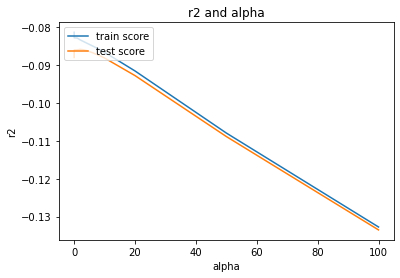

In [997]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('r2')
plt.title("r2 and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [998]:
#optimum alpha

alpha = 3.0
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
ridge.coef_

array([-7.25367036e-02,  1.08575234e-01,  1.68918272e-01,  9.78155235e-02,
        1.01882359e-01,  5.55896162e-02, -3.10302042e-03,  1.98117320e-02,
       -1.21437342e-02, -4.75454579e-02,  1.19570148e-01,  8.82121685e-02,
        8.20358495e-02,  0.00000000e+00,  2.77457381e-01,  1.90079326e-02,
        1.16513140e-02,  1.37908253e-02,  1.38722726e-02,  1.85483054e-02,
        0.00000000e+00,  3.56560729e-03,  5.52046935e-02, -3.40767250e-02,
        4.74742977e-02,  6.73672457e-02,  3.95331794e-02,  1.82451668e-02,
        9.86707815e-03,  4.67814187e-02, -3.16869715e-03,  3.85407783e-02,
       -1.73130817e-02,  4.77249117e-02,  6.15805873e-03, -3.73213649e-03,
       -4.32740624e-02, -2.04331068e-03,  2.80084608e-02,  2.22660056e-02,
        2.51436267e-02,  2.04619308e-02, -2.83043439e-02, -2.38481899e-02,
        7.00088772e-04,  2.95557761e-02,  5.51346254e-02, -2.46979961e-02,
       -1.45470643e-02,  4.46194654e-02,  4.08668424e-02, -1.72450079e-02,
        8.92971745e-02, -

In [999]:
ridge.score(X_train,y_train)

0.9445097080155822

In [1000]:
ridge.score(X_test,y_test)

0.8767245160313694

### Lasso Regression model

In [1001]:
#params = {'alpha': [0.00006,0.0006, 0.0008, 0.001, 0.002, 0.004, 0.006, 0.008 ]}
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}
lasso = Lasso()

# cross validation
lasso_model = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

lasso_model.fit(X_train1, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [1002]:
print("Optimal lambda value: ", lasso_model.best_params_)

Optimal lambda value:  {'alpha': 0.001}


In [1003]:
cv_results = pd.DataFrame(lasso_model.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.002468,0.000513,0.000907,0.000201,0.0001,{'alpha': 0.0001},-0.092317,-0.083521,-0.079623,-0.085131,...,-0.086827,0.005309,2,-0.080467,-0.083174,-0.084238,-0.082344,-0.080429,-0.082131,0.001499
1,0.001710,0.000402,0.000704,0.000400,0.001,{'alpha': 0.001},-0.091060,-0.084810,-0.078128,-0.085483,...,-0.086430,0.005153,1,-0.083480,-0.085891,-0.087121,-0.085962,-0.084331,-0.085357,0.001291
2,0.001800,0.000748,0.000999,0.000001,0.01,{'alpha': 0.01},-0.106572,-0.108326,-0.089819,-0.103343,...,-0.106132,0.010488,3,-0.103144,-0.105075,-0.107130,-0.105291,-0.104511,-0.105030,0.001289
3,0.001400,0.000490,0.000800,0.000400,0.05,{'alpha': 0.05},-0.210207,-0.228929,-0.178256,-0.200631,...,-0.210380,0.020115,4,-0.210407,-0.210839,-0.211248,-0.209541,-0.206064,-0.209620,0.001866
4,0.001399,0.000488,0.000800,0.000400,0.1,{'alpha': 0.1},-0.278579,-0.294954,-0.250984,-0.270966,...,-0.277604,0.015985,5,-0.277549,-0.273005,-0.284190,-0.278945,-0.273028,-0.277343,0.004170


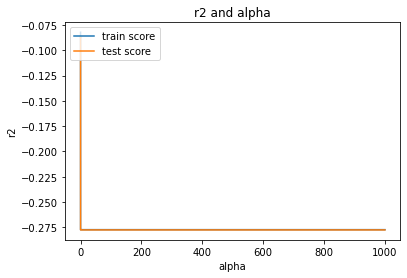

In [1004]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('r2')

plt.title("r2 and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [1005]:
#optimum alpha

alpha =0.001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.001)

In [1006]:
lasso.coef_

array([-4.23045648e-02,  9.95230111e-02,  2.24663166e-01,  9.02676914e-02,
        1.19186787e-01,  6.03469222e-02,  0.00000000e+00,  5.76624038e-02,
        0.00000000e+00, -0.00000000e+00,  1.09330868e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  4.06841405e-01,  1.86440001e-02,
        0.00000000e+00,  0.00000000e+00,  7.20163074e-03,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  6.53870996e-02,  0.00000000e+00,
        5.58590189e-02,  4.76821729e-02,  3.23074033e-02,  1.03700873e-02,
       -0.00000000e+00,  4.10250790e-02, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  1.15006279e-02, -2.87855419e-02,  0.00000000e+00,
       -0.00000000e+00, -3.72998371e-03,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.20981826e-02, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  5.96964514e-03,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  3.54669914e-02,  2.74081170e-02, -0.00000000e+00,
        7.65633122e-02, -

In [1007]:
lasso.score(X_train,y_train)

0.9239577143380369

In [1008]:
lasso.score(X_test,y_test)

0.8904134828285906

### Model Evaluation

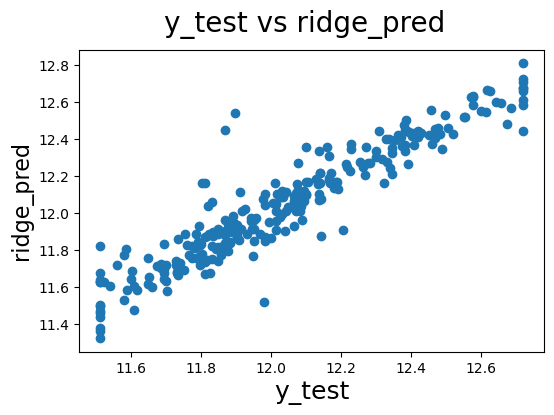

In [1009]:
ridge_pred = ridge.predict(X_test)

# Plotting y_test and y_pred to understand the spread for ridge regression.
fig = plt.figure(dpi=100)
plt.scatter(y_test,ridge_pred)
fig.suptitle('y_test vs ridge_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('ridge_pred', fontsize=16)  
plt.show()

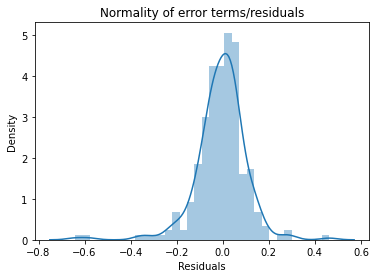

In [1010]:
y_res=y_test-ridge_pred
# Distribution of errors
sns.distplot(y_res,kde=True)
plt.title('Normality of error terms/residuals')
plt.xlabel("Residuals")
plt.show()

In [1011]:
lasso_pred = lasso.predict(X_test)

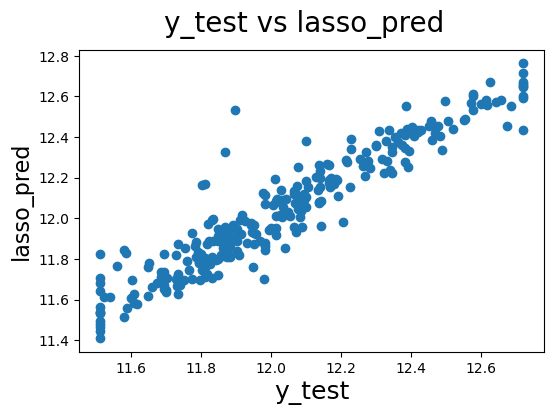

In [1012]:
# Plotting y_test and y_pred to understand the spread for lasso regression.
fig = plt.figure(dpi=100)
plt.scatter(y_test,lasso_pred)
fig.suptitle('y_test vs lasso_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('lasso_pred', fontsize=16)  
plt.show()

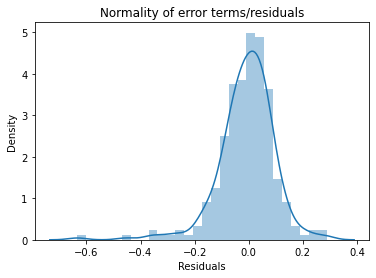

In [1013]:
y_res=y_test-lasso_pred
# Distribution of errors
sns.distplot(y_res,kde=True)
plt.title('Normality of error terms/residuals')
plt.xlabel("Residuals")
plt.show()

#### R-Squared values


- Training: Ridge: 0.9405173869929192
- Test    : Ridge: 0.8840439738982031


- Training: Lasso: 0.9239577143380369
- Test    : Lasso: 0.8904134828285906


- Optimal Lasso lambda value:  {'alpha': 6.0}
- Optimal Lasso lambda value:  {'alpha': 0.001}


In [1014]:
betas = pd.DataFrame(index=X_train.columns)
betas.rows = X_train.columns
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_

pd.set_option('display.max_rows', None)
betas.head(68)


,Ridge,Lasso
MSSubClass,-0.072537,-0.042305
LotArea,0.108575,0.099523
OverallQual,0.168918,0.224663
OverallCond,0.097816,0.090268
YearBuilt,0.101882,0.119187
YearRemodAdd,0.055590,0.060347
MasVnrArea,-0.003103,0.000000
BsmtFinSF1,0.019812,0.057662
BsmtFinSF2,-0.012144,0.000000
BsmtUnfSF,-0.047545,-0.000000


#### Business Recomendations

Which variables are significant in predicting the price of a house, and

- MSSubClass     - Identifies the type of dwelling involved in the sale
- LotArea        - Lot size in square feet
- OverallQual    - Rates the overall material and finish of the house
- OverallCond    - Rates the overall condition of the house
- YearBuilt      - Original construction date
- YearRemodAdd   - Remodel date (same as construction date if no remodeling or additions)
- TotalBsmtSF    - Total square feet of basement area
- GrLivArea      - Above grade (ground) living area square feet
- TotRmsAbvGrd   - Total rooms above grade (does not include bathrooms)
- Street_Pave    - Pave road access to property
- RoofMatl_Metal - Roof material_Metal

How well those variables describe the price of a house.

- Training: Ridge: 0.9405173869929192
- Test : Ridge: 0.8840439738982031
        
        
- Training: Lasso: 0.9239577143380369
- Test : Lasso: 0.8904134828285906